# Fit bambi model to males and females combined

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, dissoc
from aging.behavior.bio_age_model import fit_model, masked_xval, model_fun_v5, get_biological_age, compute_concentrations, concentration_interpolation, create_masks, expected_counts, compute_heldout_r2, model_setup, model_fun_v2
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig4", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [6]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

In [7]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

hypparams = {
    # "min_age": 1,
    "min_age": -10,
    # "max_age": age.max() + 5,
    "max_age": 150,
    "age_sd": 10,  # weeks
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 300,
}

### Optimize Age SD

In [8]:
keep_keys = ['heldout_ll', 'heldout_r2_total', 'heldout_r2_total_v3', 'true_ages', 'bio_ages']

In [ ]:
outs = []

for age_sd in tqdm(range(1, 20, 1)):

    hypparams["age_sd"] = float(age_sd)

    tmp = masked_xval(features, hypparams, 5, n_repeats=7, disable_tqdm=True)
    tmp = valmap(lambda v: keyfilter(lambda k: k in keep_keys, v), tmp)
    for k, v in tmp.items():
        outs.append({
            "repeat": k,
            "age_sd": age_sd,
            **v
        })
outs_df = pd.DataFrame(outs)

In [10]:
optimal_age_sd = outs_df.groupby('age_sd')['heldout_ll'].mean().idxmax()
optimal_age_sd

10

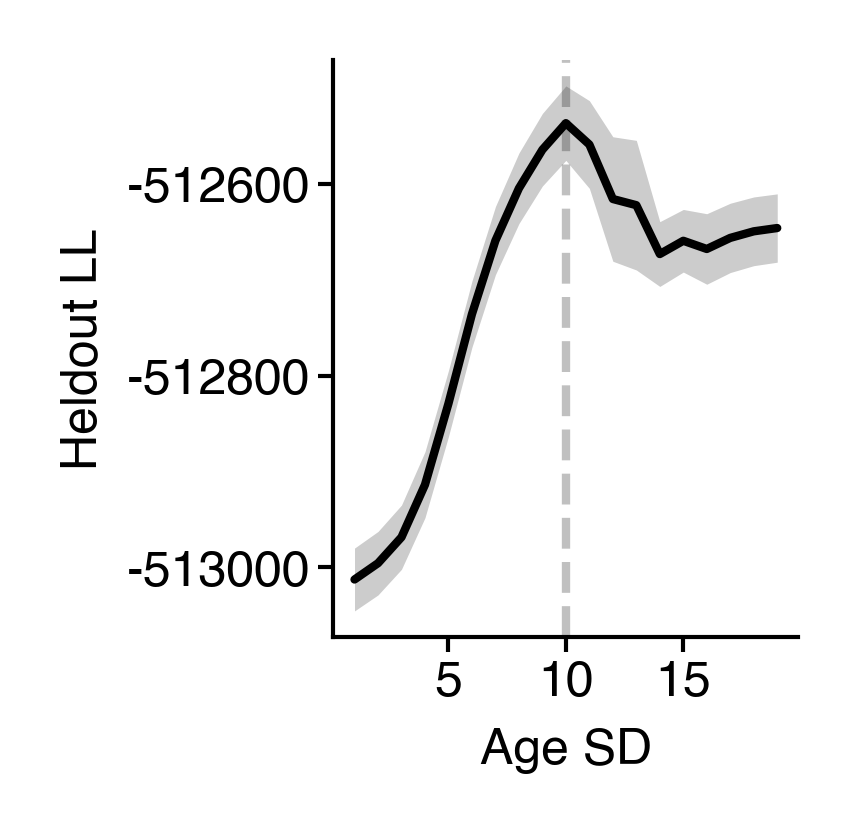

In [11]:
fig = figure(1, 1.25)
ax = sns.lineplot(
    data=outs_df,
    x="age_sd",
    y="heldout_ll",
    errorbar="se",
    err_kws=dict(lw=0),
    color="k",
)
ax.set(ylabel="Heldout LL", xlabel="Age SD")
ax.axvline(optimal_age_sd, ls='--', color='silver', zorder=-1)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-age-sd-optimization");

In [12]:
combined_results = masked_xval(features, hypparams, 5, n_repeats=25)

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
bio_age_samples = [pd.Series(v['bio_ages'], index=df.index) for v in combined_results.values()]
bio_age_samples = pd.DataFrame(bio_age_samples).T
bio_age_samples.to_parquet('/n/scratch/users/w/wg41/bio-age-model/combined-results-ontogeny-sex-predictions-2024-05-15.parquet')

In [14]:
combined_r2s = list(pluck('heldout_r2_total_v3', combined_results.values()))

## Show shuffles/controls

In [9]:
optimal_age_sd = 10

In [10]:
n_repeats = 25

In [11]:
hypparams['age_sd'] = float(optimal_age_sd)

mdl0 = masked_xval(features, hypparams, 0, n_repeats=n_repeats)
r2_0 = list(pluck('heldout_r2_total_v3', mdl0.values()))

mdl1 = masked_xval(features, hypparams, 1, n_repeats=n_repeats)
r2_1 = list(pluck('heldout_r2_total_v3', mdl1.values()))

mdl2 = masked_xval(features, hypparams, 2, n_repeats=n_repeats)
r2_2 = list(pluck('heldout_r2_total_v3', mdl2.values()))

mdl3 = masked_xval(features, hypparams, 5, n_repeats=n_repeats)
r2_3 = list(pluck('heldout_r2_total_v3', mdl3.values()))

hypparams['age_sd'] = 1e-6
mdl0_1 = masked_xval(features, hypparams, 1, n_repeats=n_repeats)
r2_0_1 = list(pluck('heldout_r2_total_v3', mdl0_1.values()))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
# shuffle syllables
np.random.seed(0)
shuff_features = deepcopy(features)
hypparams['age_sd'] = float(optimal_age_sd)

out = {}
for i in tqdm(range(n_repeats)):
    perm = np.array([np.random.permutation(58) for _ in range(len(syllable_counts_jax))])
    shuff = syllable_counts_jax[np.arange(len(syllable_counts_jax))[:, None], perm]
    shuff_features['counts'] = shuff
    tmp = masked_xval(shuff_features, hypparams, model_version=5, n_repeats=1, disable_tqdm=True)
    out[i] = tmp[0]

r2_shuff = list(pluck('heldout_r2_total_v3', out.values()))

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
# shuffle ages
np.random.seed(0)
shuff_ages = deepcopy(features)
hypparams['age_sd'] = float(optimal_age_sd)

out = {}
for i in tqdm(range(n_repeats)):
    shuff = np.random.permutation(len(features['ages']))
    shuff_ages['ages'] = features['ages'][shuff]
    tmp = masked_xval(shuff_ages, hypparams, model_version=5, n_repeats=1, disable_tqdm=True, seed=i)
    out[i] = tmp[0]

r2_age_shuff = list(pluck('heldout_r2_total_v3', out.values()))

  0%|          | 0/25 [00:00<?, ?it/s]

In [14]:
# produce shuffles, compare to observed r2s
np.random.seed(0)

shuff_features = deepcopy(features)

shuff_out = {}
for i in tqdm(range(n_repeats)):
    shuff_features['mice'] = np.random.permutation(features['mice'].T).T
    shuff_results = masked_xval(shuff_features, hypparams, 5, n_repeats=1, disable_tqdm=True, seed=i)
    shuff_out[i] = shuff_results[0]

shuff_r2s = list(pluck('heldout_r2_total_v3', shuff_out.values()))

  0%|          | 0/25 [00:00<?, ?it/s]

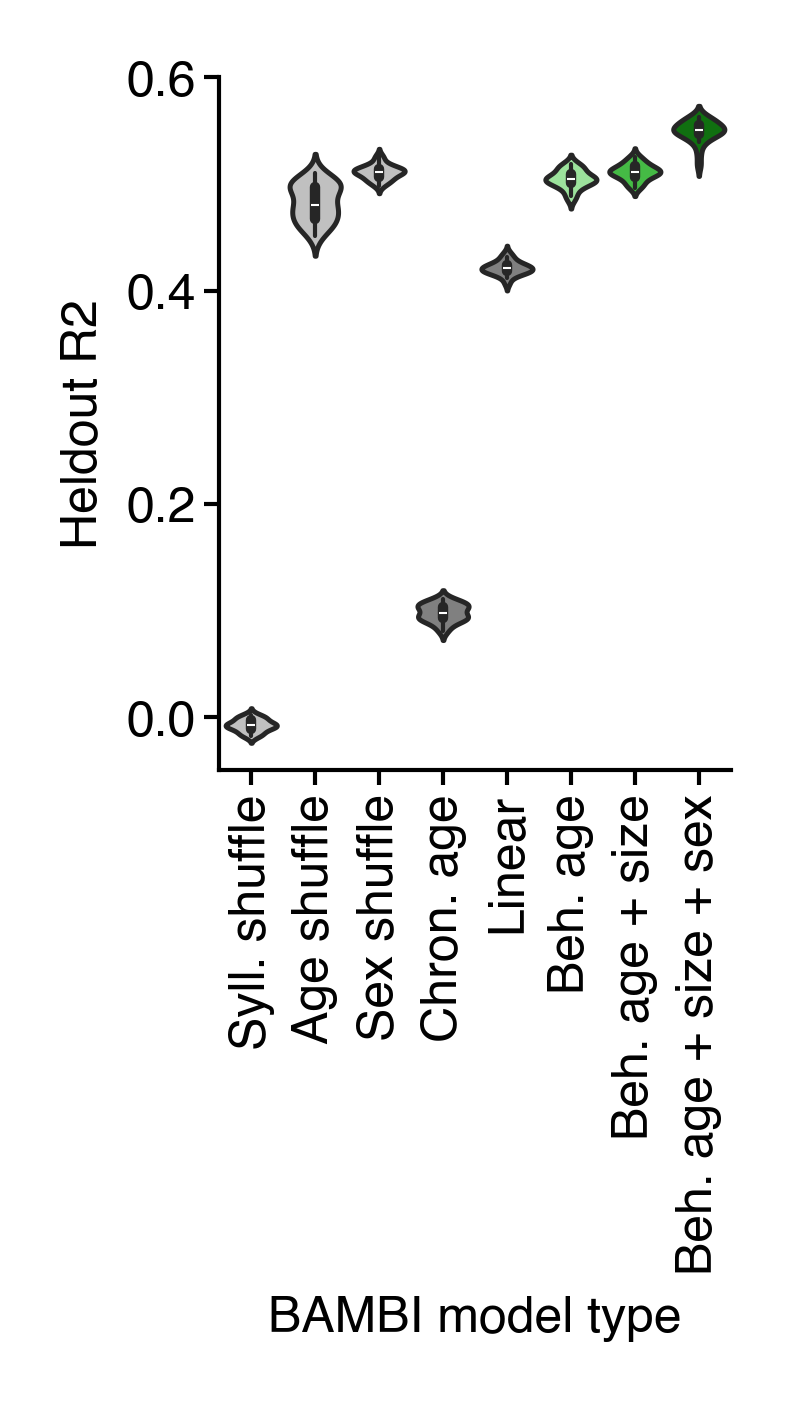

In [17]:
plt_data = {
    "Syll. shuffle": r2_shuff,
    "Age shuffle": r2_age_shuff,
    "Sex shuffle": shuff_r2s,
    "Chron. age": r2_0_1,
    "Linear": r2_0,
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
    "Beh. age + size + sex": r2_3,
}

fig = figure(1.1, 1.5)
ax = sns.violinplot(
    data=plt_data,
    palette=["silver", "silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    width=0.8, linewidth=0.6,
    inner_kws=dict(box_width=1.25, whis_width=0.5),
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
    ylim=(-0.05, 0.6),
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-r2-model-comparison");

## Get males vs females

In [10]:
# hypparams['n_development_splines'] = 5

In [16]:
hypparams['min_age'] = 0
hypparams['max_age'] = 110

In [17]:
hypparams['age_sd'] = 1e-6
mdl = fit_model(features, hypparams, 5)

In [18]:
labels = LabelEncoder().fit_transform(np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))]))

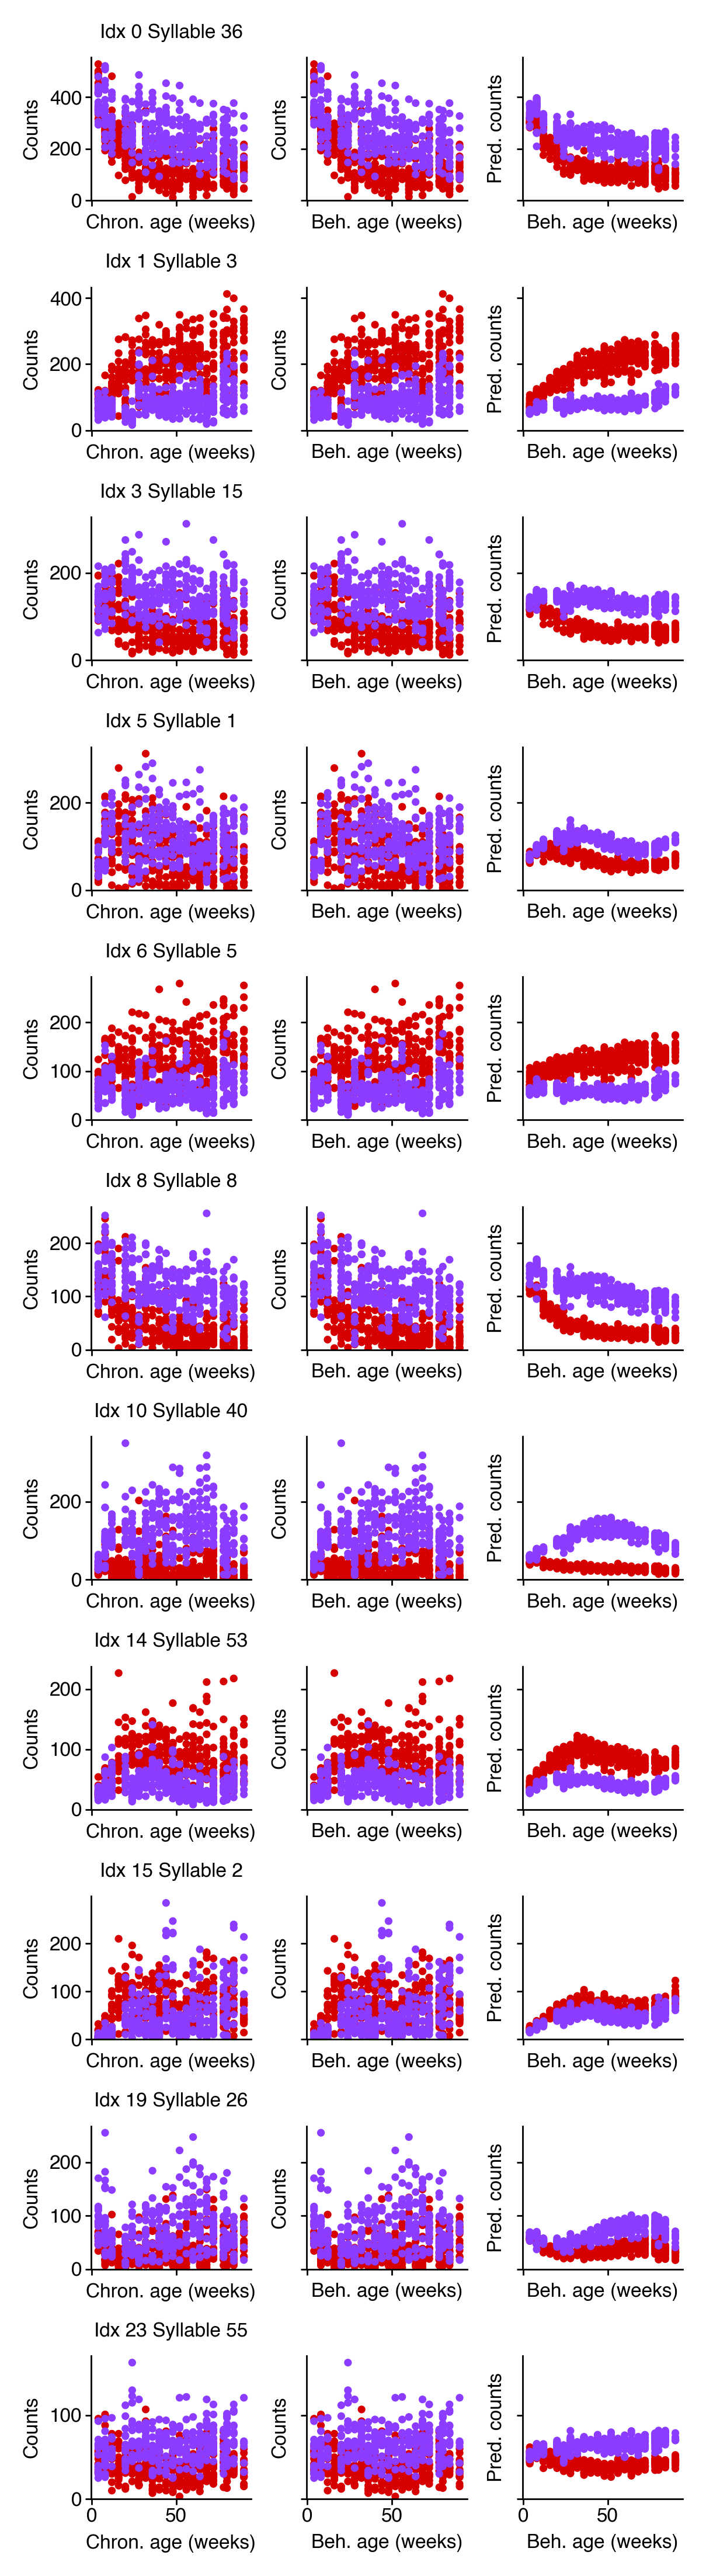

In [19]:
# male is red, female is purple
example_mice = [0, 1]

mask = []
for m in example_mice:
    mask.append(labels == m)
mask = reduce(or_, mask)

sylls = [0, 1, 3, 5, 6, 8, 10, 14, 15, 19, 23]
fig, ax = plt.subplots(len(sylls), 3, figsize=(3, len(sylls)), sharex=True)

true_age = mdl["true_ages"][mask]
bio_age = mdl["bio_ages"][mask]
counts = mdl["counts"][mask]
pred_counts = mdl["predicted_counts"][mask]

for a, syll, i in zip(ax, map(lambda i: sort_idx[i], sylls), sylls):
    max_counts = max([counts[:, syll].max(), pred_counts[:, syll].max()]) * 1.05
    a[0].scatter(true_age, counts[:, syll], s=2.5, c=labels[mask], cmap=cc.cm.glasbey, vmax=256, vmin=0)
    a[0].set(title=f"Idx {i} Syllable {syll}", ylabel="Counts", xlabel="Chron. age (weeks)", ylim=(0, max_counts))

    a[2].scatter(bio_age, pred_counts[:, syll], s=2.5, c=labels[mask], cmap=cc.cm.glasbey, vmax=256, vmin=0)
    a[2].set(ylabel="Pred. counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

    a[1].scatter(bio_age, counts[:, syll], s=2.5, c=labels[mask], cmap=cc.cm.glasbey, vmax=256, vmin=0)
    a[1].set(ylabel="Counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

sns.despine()
fig.tight_layout()

# saver(fig, "sex-ontogeny-true-vs-predicted-counts");

In [20]:
list(mdl['params'])

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

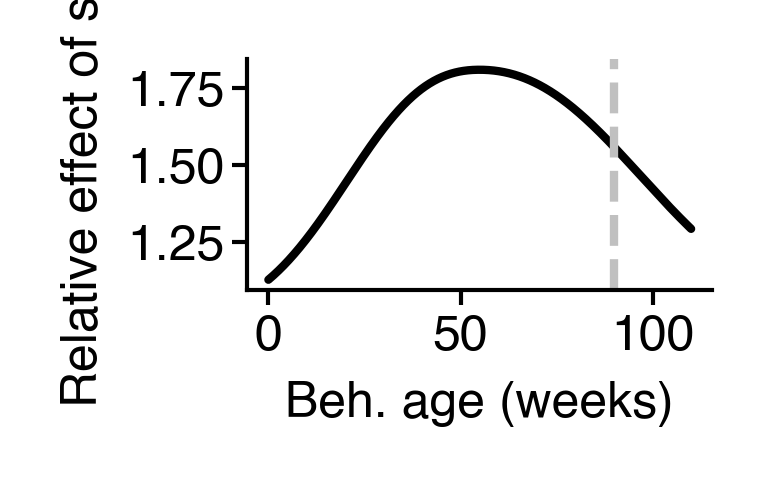

In [26]:
x = mdl['params']['development_weights']
dev = (x @ mdl['init_components'].bases['development']).squeeze()

comps = mdl['init_components']

dev = np.exp(dev)

fig = figure(1, 0.5)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
# plt.xlim(0, None)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()
ax.axvline(90, color='silver', ls='--')
# saver(fig, "ontogeny-effect-of-sex");

## Make ontogeny sex age plot

In [23]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        # aspect="equal",
    )
    sns.despine()
    return fig

In [24]:
age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=labels),
)

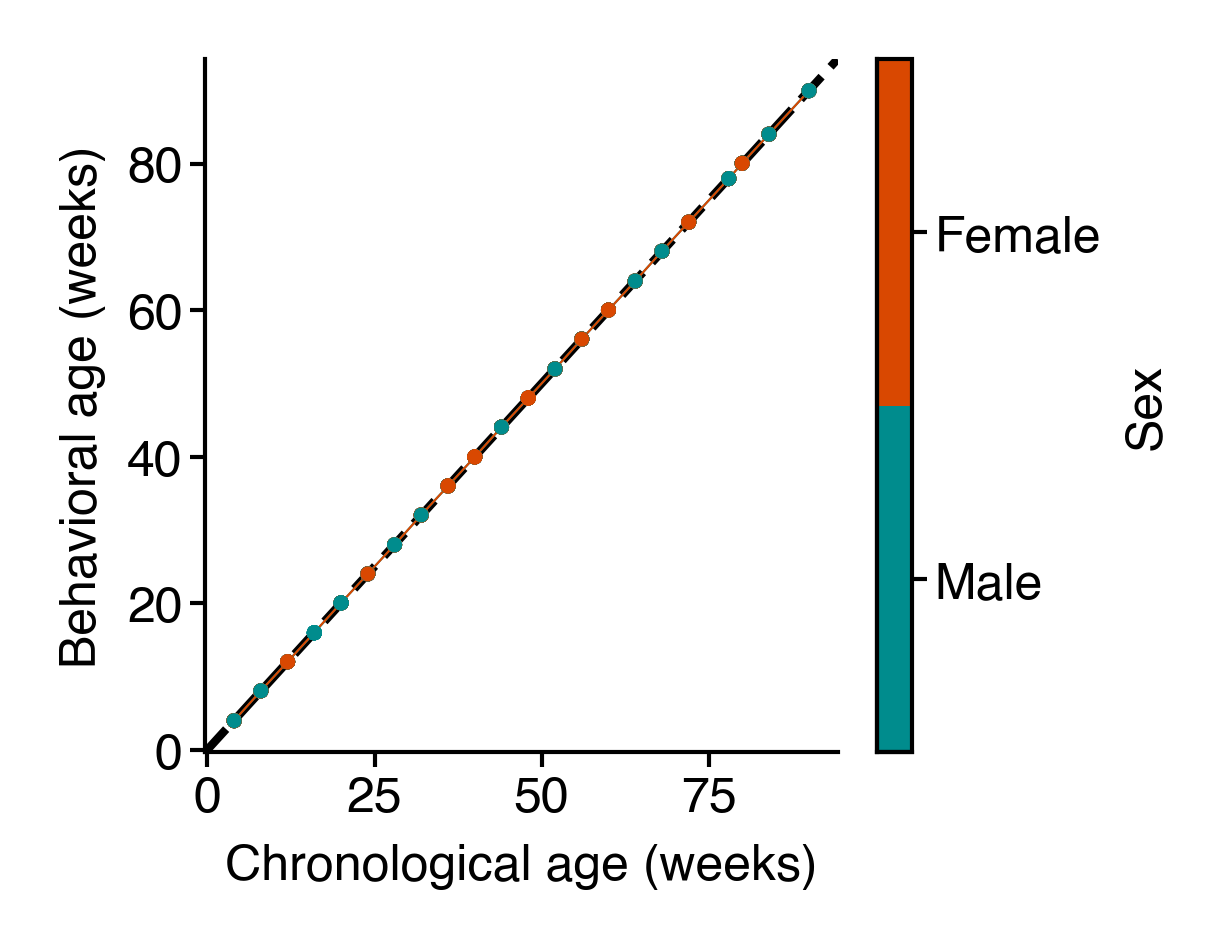

In [25]:
fig = make_plot(age_df, 1.7, 1.5)
# saver(fig, "ontogeny-sex-chron-vs-beh-age-all-timepoints");

## PCA on model predictions

In [45]:
from sklearn.decomposition import PCA

In [46]:
list(mdl)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'age_likelihoods',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each']

In [47]:
mdl['predicted_counts'].shape

(676, 58)

In [48]:
pc = mdl['predicted_counts']
pc = pc / pc.sum(1, keepdims=True)

In [49]:
pca = PCA(n_components=2)
scores = pca.fit_transform(pc)
scores_df = pd.DataFrame(scores, index=df.index)
scores_df['sex'] = labels

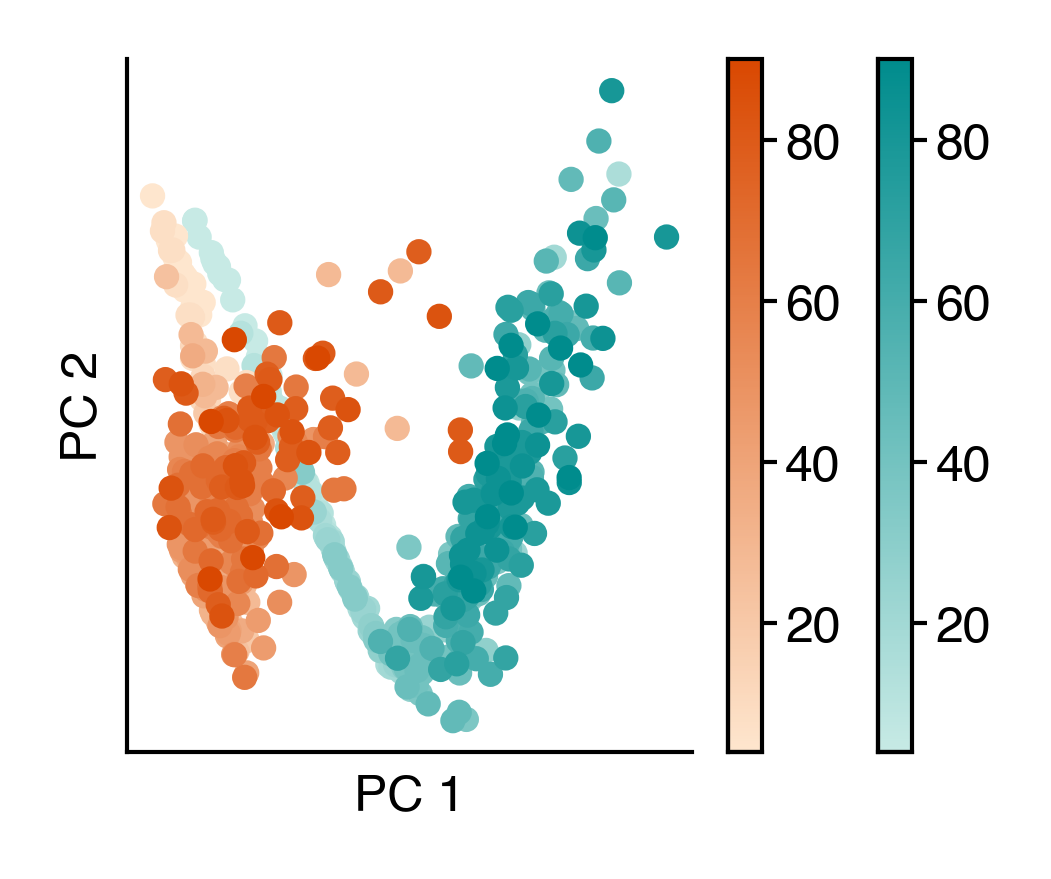

In [55]:
fig = figure(1.9, 1.5)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df.index.get_level_values('age'), cmap=cm, s=5)
    cb = fig.colorbar(im, ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "model-based-pca-males-females");

In [56]:
scores_df['bio_age'] = mdl['bio_ages']

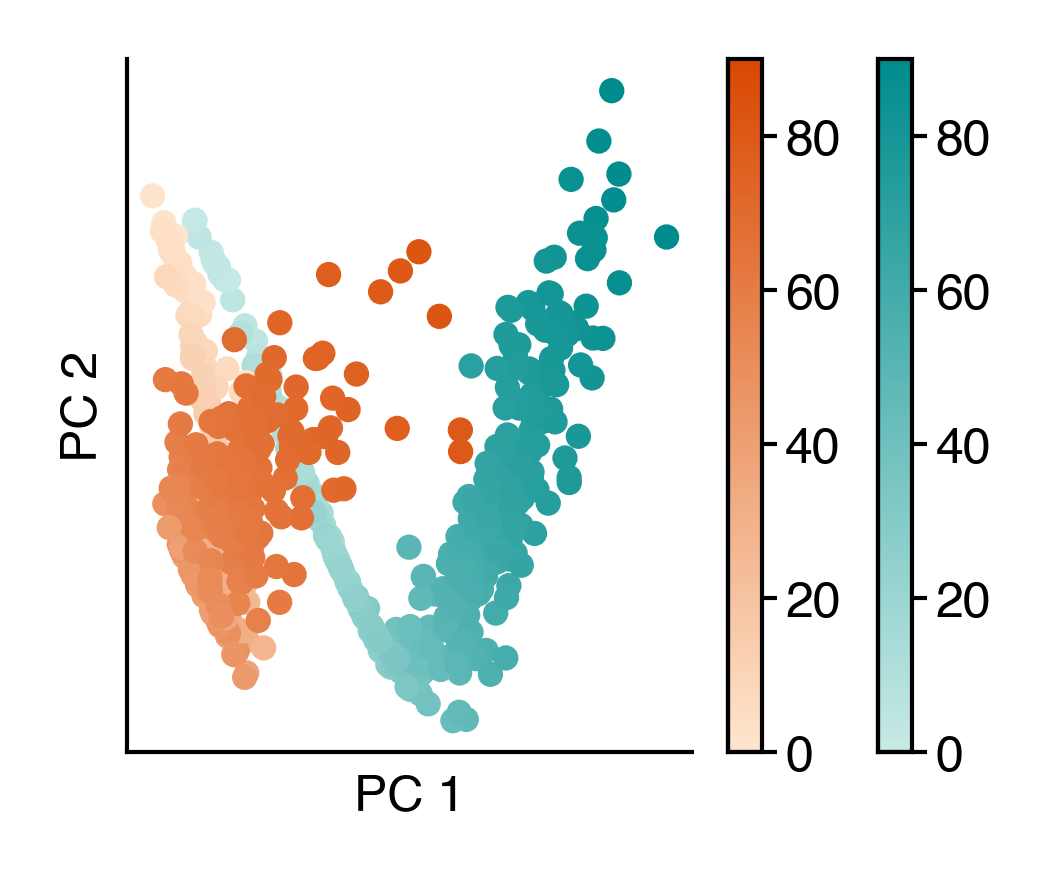

In [58]:
fig = figure(1.9, 1.5)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df['bio_age'], cmap=cm, s=5, vmin=0, vmax=90)
    cb = fig.colorbar(im, ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "model-based-pca-males-females-bio-age");